 # White House Visitor Logs
  ## A Data Exploration Project
   ### By Jacqueline Tiefert

The Biden-Harris Administration was the first administration to publish White House visitor logs from their first year in office.
 It contains data on every public visitor to the Executive Branch over the year 2021. This exciting dataset can help us get a pulse on the nation's concerns.For example, one of President Biden's promises was to prioritize climate change. He placed National Climate Advisors throughout the Executive Branch. Will those advisors prove to be one of the nation's most frequently visited people? This dataset will answer that question as well as reveal other interesting details, such as whether the President, First Lady, or the Vice President received more visitors during their first year in office.

Are you someone who might like to plan a future visit to the Capitol? Precise time logs in this dataset allow us to determine the route which provides the shortest wait times between booking an appointment date and getting that appointment. We can also see which building is associated with the shortest wait times and which received the most visitors. 
 
This notebook uses a merged file of ten csv files downloaded from https://www.whitehouse.gov/disclosures/visitor-logs/. The original data files on the White House website are arranged by month and give the total number of visitor entries per month. Can you guess which month received the most entries? That was July, 2021, which had 5,617 visitor log entries!  Please also note that as of February, 2022, not all of the data from 2021 is available. We have data from January to October, 2021. This notebook will be updated when more data from 2021 becomes publicly available, and this last sentence will be changed to reflect that. 

Now let's dig into this dataset! First we will import the csv file. CSV is short for "comma separated values" and represents how the data is stored. It's a little chunk of code to read in the file: 
  

In [1]:
from csv import reader
opened_file = open('combined.csv')
read_file = reader(opened_file)
whdf = list(read_file)

import pandas as pd
import numpy as np

whdf = pd.read_csv('combined.csv')

from csv import * 
whdf.dtypes
whdf.shape



(21334, 28)

This shows that our dataframe has 21,334 rows and 28 columns. 
Now let's look at what those column headers are. Below we will see the column header on the left side and the first entry of data down the right side.

In [2]:
columns = whdf.iloc[0,:]
print(columns)

NAMELAST                       AIYER
NAMEFIRST                   KRISHNAN
NAMEMID                            V
UIN                           U20190
BDGNBR                        135620
ACCESS_TYPE                       VA
TOA                  1/26/2021 19:58
POA                            B0401
TOD                              NaN
POD                              NaN
APPT_MADE_DATE       1/26/2021 19:51
APPT_START_DATE      1/26/2021 20:00
APPT_END_DATE        1/26/2021 23:59
APPT_CANCEL_DATE                 NaN
TOTAL_PEOPLE                       1
LAST_UPDATEDBY                    AL
POST                             WIN
LASTENTRYDATE        1/26/2021 19:51
TERMINAL_SUFFIX                   AL
VISITEE_NAMELAST            McCarthy
VISITEE_NAMEFIRST               John
MEETING_LOC                       WH
MEETING_ROOM                  EW 121
CALLER_NAME_LAST                 LIN
CALLER_NAME_FIRST             AUSTIN
CALLER_ROOM                      NaN
DESCRIPTION                      NaN
R

Here is a brief description of the column headers which are relevant to this data exploration:

1. **NAMELAST**: last name of the visitor
2. **NAMEFIRST**: first name of the visitor
3. **APPT_MADE_DATE**: the date when then appointment was created
4. **APPT_START_DATE**: the date when the appointment was attended
5. **VISITEE_NAMELAST**: the last name of the person visited
6. **VISITEE_NAMEFIRST**: the first name of the person visited
7. **MEETING_LOC**: the building name where the meeting took place

In [3]:
meeting_location = whdf.iloc[:,21]
print(meeting_location.unique())

['WH' 'NEOB' 'EEOB' 'MEETING_LOC' 'OEOB' 'VPR' nan]


This little code snippet above referenced the MEETING_LOC column header by index number 21 and then extracted
all of the unique values from that column. As you can see from the result, there are 7 unique values, include nan (Not A Number) which indicates 'no value' or a blank/missing field in Python Pandas library. It also includes the header name once. A little snooping on Google provides an explanation for the other abbreviations:

1. **WH**: White House
2. **NEOB**: New Executive Office Building
3. **EEOB**: Eisenhower Executive Office Building
4. **OEOB**: Old Executive Office Building
5. **VPR**: Vice President's Residence (office inside Naval Observatory)

The Old Executive Office Building and the Eisenhower Executive Office Building are actually two names for the same building. Looking in Google maps, here are the relative locations for the White House, the Eisenhower Exeuctive Office Building, and the New Executive Office Building:
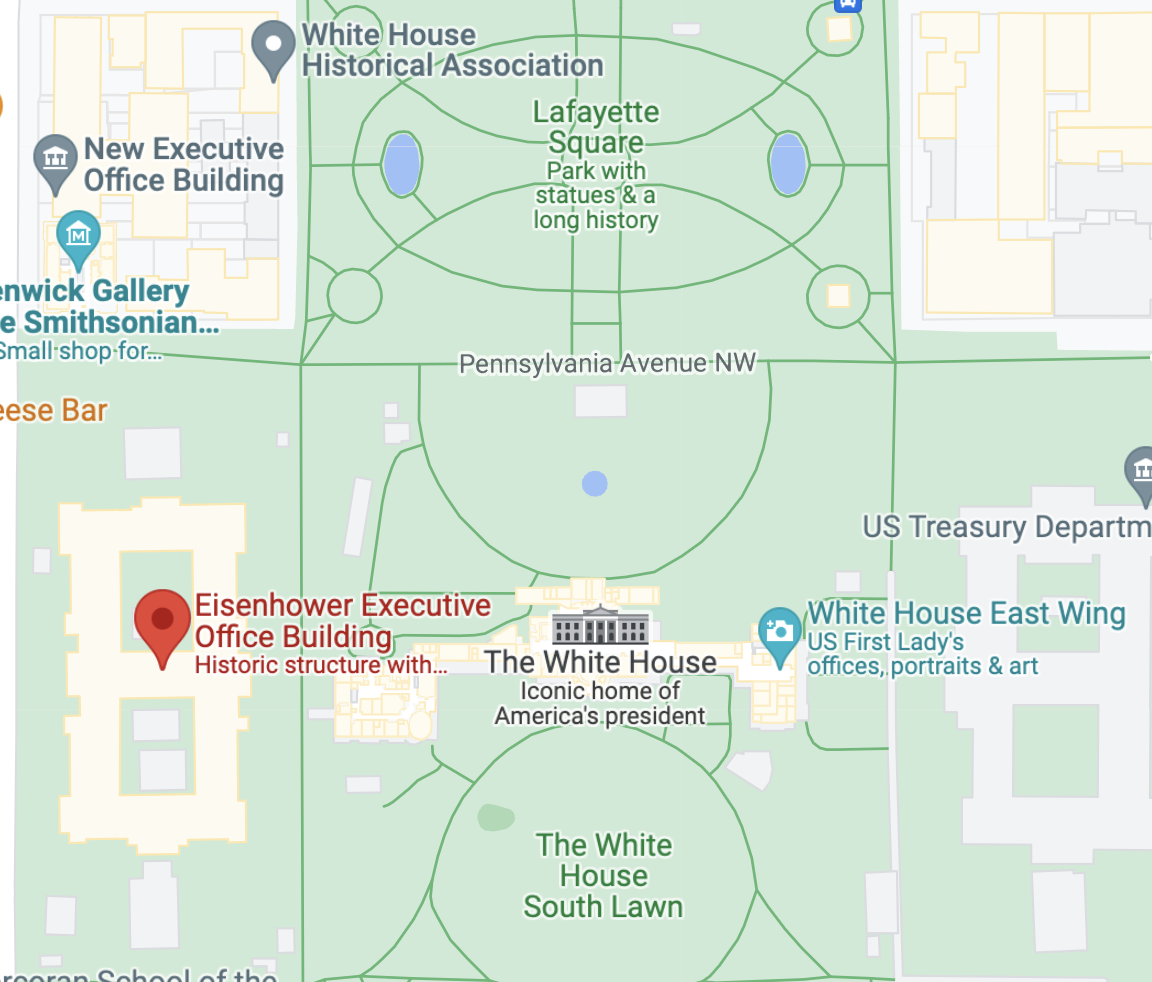

Because the Eisenhower Executive Office Building is located closer to the White House than the New Executive Office Building, I predict that there will be a longer wait time to get an appointment because of added security. This is just a guess. Running a bit of code next will tell us whether I am right or not. We can determine an aggregate turnaround time for each building by subtracting the time between the APPT_MADE_DATE column and the APPT_START_DATE column. The truncated table below shows the portion of the table which shows the relevant columns. 

In [4]:
import datetime as dt

time_per_building = whdf.iloc[:,[10,11,14,21]]

print(time_per_building)

        APPT_MADE_DATE  APPT_START_DATE TOTAL_PEOPLE MEETING_LOC
0      1/26/2021 19:51  1/26/2021 20:00            1          WH
1       1/26/2021 9:04  1/26/2021 11:00            6          WH
2       1/26/2021 9:04  1/26/2021 11:00            6          WH
3       1/13/2021 9:11  1/25/2021 10:00            1        NEOB
4       1/22/2021 8:56  1/25/2021 11:00            1        NEOB
...                ...              ...          ...         ...
21329    10/5/21 11:37     10/5/21 0:00            3        OEOB
21330     9/30/21 3:52    10/12/21 0:00            2        OEOB
21331    10/25/21 9:02    10/26/21 0:00            2        OEOB
21332    10/6/21 10:00     10/6/21 0:00            2        OEOB
21333   10/19/21 11:24    10/19/21 0:00            3        OEOB

[21334 rows x 4 columns]


In [5]:
import datetime as datetime
import re
time_per_building = whdf.iloc[:,[10,11,14,21]]
whdf['duration'] = [0] * whdf.count()

def sanitizeDate(dateString):
    if len(dateString) < 10:
      dateString = dateString + " 00:00"
    lastIndexOfslash = dateString.rfind('/')+1
    lastIndexOfspace = dateString.rfind(' ')
    yearValue = dateString[lastIndexOfslash:lastIndexOfspace]
    if len(yearValue) == 2:
        return datetime.datetime.strptime(dateString, '%m/%d/%y %H:%M')
    else:
        return datetime.datetime.strptime(dateString, '%m/%d/%Y %H:%M')

#def time_duration():
datetime_obj2 = datetime_obj = None
for row in time_per_building.index:
    datetime_string = str(time_per_building["APPT_MADE_DATE"][row])
    isInRightFormat = re.match('\d+/\d+/\d+', datetime_string)
    if isInRightFormat is not None:
        datetime_obj = sanitizeDate(datetime_string)

    datetime_string2= str(time_per_building["APPT_START_DATE"][row])
    isInRightFormat = re.match('\d+/\d+/\d+', datetime_string2)
    if isInRightFormat is not None:
        datetime_obj2 = sanitizeDate(datetime_string2)
    diff = datetime_obj2 - datetime_obj
    whdf['duration'][row] = abs(diff)
   
print( whdf['duration'])


/var/folders/01/8qkcw5d910nfzr664dx7b5j80000gn/T/ipykernel_993/7429548.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  whdf['duration'][row] = abs(diff)


0                  0:09:00
1                  1:56:00
2                  1:56:00
3         12 days, 0:49:00
4          3 days, 2:04:00
               ...        
21329             11:37:00
21330    11 days, 20:08:00
21331             14:58:00
21332             10:00:00
21333             11:24:00
Name: duration, Length: 21334, dtype: object


This code shows the index of the row number and difference in time between the date the appointment was scheduled and then attended. As you can see from comparing the two truncated tables above, the first row shows an appointment that was scheduled and then attended just 9 minutes later! The second row shows an appointment which was made and then was able to be attended just 1 hour and 56 minutes later. However, scanning down this second table, we can see that some appointments were booked days or weeks in advance. Which building do you think had the longest wait time, overall?

In [6]:
whdf_sliced = whdf.loc[:, ["MEETING_LOC", "duration"]]
whdf_sorted = whdf_sliced.sort_values(['duration'], ascending=True)
#print(whdf_sorted)
import numpy as np
building_stats = whdf.pivot_table(index ="MEETING_LOC", values=["duration"], aggfunc=np.sum)
print(building_stats)

                         duration
MEETING_LOC                      
EEOB          1138 days, 18:47:00
MEETING_LOC       8 days, 1:36:00
NEOB           3668 days, 9:22:00
OEOB          16967 days, 6:31:00
VPR           5453 days, 16:20:00
WH           16007 days, 17:01:00


The building with the shortest wait time is actually the New Executive Office Building (NEOB) with a total wait time of 3,668 days, 9 hours, and 22 minutes. The longest turnaround time in 2021 was for the Eisenhower Executive Office Building, which is also the Old Executive Office Building. Adding their two numbers together gives a whopping 18, 105 days! The White House had the second highest wait time of 16,007 days. The Vice President's Office, in comparison, was a little over three times as fast. That's quite a difference between visiting the President or the Vice President!

Now I want to know which building logged the most visitor entries to get a sense of how many parties attended each. The following code snippet produces a dictionary with total number of visitor log entries per building. 

In [7]:
mostpopular_locations = {"WH":0, "NEOB":0, "EEOB":0, "OEOB":0, "VPR":0}
for m in meeting_location:
    if m in mostpopular_locations:
        mostpopular_locations[m] +=1
    else:
        mostpopular_locations[m] =1
print(mostpopular_locations)

{'WH': 8064, 'NEOB': 1137, 'EEOB': 837, 'OEOB': 10326, 'VPR': 960, 'MEETING_LOC': 9, nan: 1}


Not surprisingly, the New Executive Office Building (NEOB) got about 1/10th the number of visitors as the Eisenhower Executive Office Building (EEOB and OEOB added together). No wonder it has the shortest turnaround time for getting an appointment! However, note that this does not mean the NEOB is very efficient in processing visitors. For only 1/10th the number of visitors, it is only about 5 times as fast to get an appointment, not 10 times. That's half as efficient as you would expect. Which was the least efficient Executive Office? 
  Dividing the total number of days waiting by the total number of logged visits per building, we get:
  1. White House: 1.9 days / visitor entry
  2. New Executive Office Building: 3.22 days / visitor entry
  3. Eisenhower Executive Office Building: 1.62 days / visitor entry
  4. Vice President's Residence: **5.6 days** / visitor entry

Interesting! Now that we know an average wait time to visit the Vice President is about 6 days, let's see who was the most popular with the public in 2021, measured by the number of visitor logs received: the Prisident, the Vice President, or the First Lady?


In [8]:
print("President's number of visitor logs:", whdf["VISITEE_NAMEFIRST"].value_counts().loc["POTUS"])
print("Vice President's number of visitor logs:", whdf["VISITEE_NAMEFIRST"].value_counts().loc["VPOTUS"])
print("First Lady's number of visitor logs:", whdf["VISITEE_NAMEFIRST"].value_counts().loc["FLOTUS"])

President's number of visitor logs: 3406
Vice President's number of visitor logs: 115
First Lady's number of visitor logs: 131


Even more interesting, the Vice President recorded the least amount of visitor logs. The First Lady actually received more visitor log entries than the Vice President! That was definitely not expected! First Lady Jill Biden is certainly more popular than I was expecting! 
   Now I am curious to find out exactly who was the most frequently visited official from across all of the visitor logs. Will it be a Climate National Advisor, as previously mentioned? Or does the public meet with Transportation, Education, National Security, or other officials more? Let's find out! 

In [34]:
visitee_lastname = whdf.iloc[:,19]
lastname_counts ={}
for item in visitee_lastname:
    if item not in lastname_counts:
        lastname_counts[item] = 1
    else:
            lastname_counts[item]+= 1
#print(lastname_counts)
for key, value in sorted(lastname_counts.items(), key=lambda kv: kv[1], reverse=True):
  print("%s: %s" % (key, value))


nan: 3708
Via: 862
Nelson: 583
Teleky: 549
Vallejo: 437
Butler: 301
Taylor: 271
Silva: 263
Sullivan: 243
Rastegar: 242
Guyton: 218
Conley: 216
McGurk: 199
Schaffer: 190
Chhabra: 178
Lang: 175
Neuberger: 175
Donilon: 171
Gonzalez: 162
Isen: 161
Newton: 154
Panzarella-Tarr: 153
Dirksen: 152
Tobin: 140
Tolliver: 140
Carrasquillo: 136
Stanwich: 134
Richmond: 132
Evans: 124
Leaf: 122
Hart: 108
NELSON: 107
Gelfond: 93
LUDWIG: 91
Sanders: 88
Macklin: 86
Joyce: 81
Finer: 80
Abercrombie: 80
Dietrich: 80
Collins: 79
McEldowney: 78
Satkowiak: 76
Stambaugh: 75
Lander: 74
Doyle: 71
Reilly: 71
Rodriguez: 71
MICHEL: 67
Stewart: 67
Green: 67
Garner: 66
Harley: 66
Dien: 66
M.: 65
DeCesaro: 64
R.: 63
Campbell: 61
Berry: 61
Li: 61
Nyirandutiye: 60
Page: 60
St.: 58
Browne: 57
Michel: 55
Velz: 54
Qureshi: 54
Starfield: 54
McCarthy: 52
Finney: 52
Solomon: 51
Burton: 51
Brennan: 51
Grove: 51
Strasser: 50
Cole: 48
Endicott: 48
Neuman: 48
Cerrato: 47
Singh: 46
Etim: 46
REED: 46
Ricchetti: 45
Shull: 44
Venkatra

Searching by last name of visitee and placing the results in descending order, we can see that Dan Via was THE most visited person in the Executive Branch, after the President. Dan Via is the Deputy Director of Ceremonies and Protocol for the Unites States Air Force. It looks like ceremonial functions for the military beat the climate! We just might need some climate ceremonies in the future! (joke).The second most visited person was David Nelson, a Deputy Social Secretary. Deputy Social Secretaries make guest lists, seating arrangements, and menus for official state functions. It appears again that people are mostly visiting about the set up of ceremonies.
  In the code snippet below, I am just checking that the values for last name of Nelson belong to the same first name because Nelson is a common last name. It looks like, below, that it checks out. 

In [10]:
name_nelson = whdf["VISITEE_NAMELAST"] == "Nelson"
result = whdf.loc[name_nelson, "VISITEE_NAMEFIRST"]
print(result)

2995     David
4604     David
4611     David
6745     David
6746     David
         ...  
20851    David
20854    David
20970    David
21150    David
21210    David
Name: VISITEE_NAMEFIRST, Length: 583, dtype: object


 The third most visited person was Ed Teleky. Similar to the former, a quick Google search reveals that he is the Director of Ceremonies for the White House. 
   I have to say that I am a bit surprised by these results. I can't wait to see what the year 2022 will tell us in data. 

And, finally, just for a little bit of fun, this last little table below tells us that if your first name was Michael or your last name was Smith, you were most likely a top visitor to the Executive Branch, by name frequency. 

In [11]:
whdf.describe()

,NAMELAST,NAMEFIRST,NAMEMID,UIN,BDGNBR,ACCESS_TYPE,TOA,POA,TOD,POD,...,VISITEE_NAMELAST,VISITEE_NAMEFIRST,MEETING_LOC,MEETING_ROOM,CALLER_NAME_LAST,CALLER_NAME_FIRST,CALLER_ROOM,DESCRIPTION,RELEASEDATE,duration
count,21334,21333,21333,21333,10675,21333,13972,4663,2239,6959,...,17626,21332,21333,21333,21333,21333,9,17201,4191,21334
unique,7839,3748,27,7811,1375,2,9250,20,1371,18,...,1006,724,6,924,427,293,1,16,8,3661
top,SMITH,MICHAEL,N,U27154,178263,VA,7/4/2021 18:52,B0401,3/31/2021,B04,...,Via,POTUS,OEOB,SOUTH LAWN,BUTLER,NICOLE,CALLER_ROOM,11/1/2021,7/29/2021,3 days 13:27:00
freq,143,465,5058,1155,40,21324,59,2481,42,3761,...,862,3406,10326,1238,2420,2415,9,5616,1508,133


Was exploring this dataset fun for you? Do you want to start learning Python, too? I am learning online from https://www.dataquest.io/. The thing I like best about it is that there are no videos, so you can go at your speed reading pace (which is faster than watching videos for a lot of people) and easily navigate back to review topics (no rewinding videos to find that magic spot!). I highly recommend giving their learning platform a try! It is very beginner-friendly. See you in my next project! 